/var/folders/c4/54xhkqmn06z28l_sd5vnm5700000gn/T/ipykernel_7090/3568701077.py:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


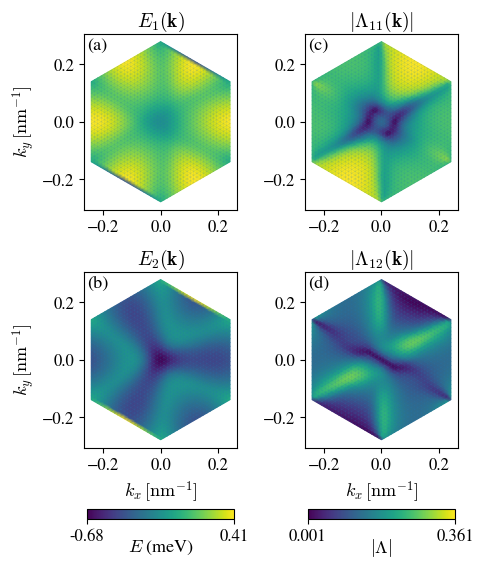

In [110]:
 
import os, glob, csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
 
def _read_k_index_table(in_dir):
    path = os.path.join(in_dir, "k_index.csv")
    with open(path, "r", newline="") as f:
        return [(int(r["k_index"]), float(r["kx"]), float(r["ky"])) for r in csv.DictReader(f)]

# 
def collect_eplus_bands(flat_dir):
    files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))
    kx_list, ky_list, e0_list, e1_list, idx_list = [], [], [], [], []
    for f in files:
        z = np.load(f, allow_pickle=True)
        if "Eplus_flat" not in z:
            continue
        k_index = int(z["k_index"])
        kvec    = np.asarray(z["k"], float)
        Eplus   = np.asarray(z["Eplus_flat"], float)
        if Eplus.size < 2:
            continue
        kx_list.append(kvec[0]); ky_list.append(kvec[1])
        e0_list.append(float(Eplus[0])); e1_list.append(float(Eplus[1]))
        idx_list.append(k_index)
    return (np.array(kx_list, float),
            np.array(ky_list, float),
            np.array(e0_list, float),
            np.array(e1_list, float),
            idx_list)

def collect_lambda_elem(flat_dir, *, layer=0, sym_idx=0, elem=(0,0)):
    files = sorted(glob.glob(os.path.join(flat_dir, "flat_k*.npz")))
    kx_list, ky_list, v_list, idx_list = [], [], [], []
    i, j = elem
    for f in files:
        z = np.load(f, allow_pickle=True)
        if "L0flat" not in z and "L1flat" not in z:
            continue
        k_index = int(z["k_index"])
        kvec    = np.asarray(z["k"], float)
        Lflat   = np.asarray(z["L0flat"] if layer == 0 else z["L1flat"])
        if sym_idx >= Lflat.shape[0]:
            continue
        B = np.asarray(Lflat[sym_idx], complex)   # (2,2)
        v = float(np.abs(B[i, j]))
        kx_list.append(kvec[0]); ky_list.append(kvec[1])
        v_list.append(v); idx_list.append(k_index)
    return (np.array(kx_list, float),
            np.array(ky_list, float),
            np.array(v_list, float),
            idx_list)

# 
def _tripcolor(ax, tri, vals, *,
               title=None, vmin=None, vmax=None,
               show_pts=False, show_edges=False,
               tickvals=(-0.2, 0.0, 0.2),
               xlabel=True, ylabel=True,
               title_size=14, label_size=13, tick_size=12):
    im = ax.tripcolor(tri, vals, shading="gouraud", vmin=vmin, vmax=vmax)
    if show_edges:
        ax.triplot(tri, lw=0.25, alpha=0.25)
    if show_pts:
        ax.scatter(tri.x, tri.y, s=4, alpha=0.25)
    ax.set_aspect("equal", adjustable="box")

    # ticks and labels
    ax.set_xticks(tickvals); ax.set_yticks(tickvals)
    ax.tick_params(labelsize=tick_size)
    if xlabel:
        ax.set_xlabel(r"$k_x\,[\mathrm{nm}^{-1}]$", fontsize=label_size)
    if ylabel:
        ax.set_ylabel(r"$k_y\,[\mathrm{nm}^{-1}]$", fontsize=label_size)
    if title:
        ax.set_title(title, pad=3, fontsize=title_size)
    return im

# 
def plot_two_col_two_row_disp_and_lambda(
    flat_dir_disp,
    flat_dir_lambda,
    *,
    layer=0,
    sym_idx=0,
    out_path=None,
    show_points=False,
    show_edges=True,
    share_lambda_scale=True
):
    # Collect
    kx, ky, e0c, e1c, _ = collect_eplus_bands(flat_dir_disp)
    e0, e1=(e0c-0.00145947)*1000, (e1c-0.00145947)*1000
    tri_e  = mtri.Triangulation(kx, ky)
    vmin_e = float(min(e0.min(), e1.min()))
    vmax_e = float(max(e0.max(), e1.max()))

    kx11, ky11, lam11, _ = collect_lambda_elem(flat_dir_lambda, layer=layer, sym_idx=sym_idx, elem=(0,0))
    kx12, ky12, lam12, _ = collect_lambda_elem(flat_dir_lambda, layer=layer, sym_idx=sym_idx, elem=(0,1))
    tri_11 = mtri.Triangulation(kx11, ky11)
    tri_12 = mtri.Triangulation(kx12, ky12)

    if share_lambda_scale:
        vmin_L = float(min(lam11.min(), lam12.min()))
        vmax_L = float(max(lam11.max(), lam12.max()))
    else:
        vmin_L = vmax_L = None

    # --- Figure & grid: 2 rows (no dedicated cbar row), tight but positive wspace ---
    fig = plt.figure(figsize=(7.6, 6.6), constrained_layout=False)
    gs  = fig.add_gridspec(2, 2, wspace=-0.4, hspace=0.35)

    # Axes
    ax_a = fig.add_subplot(gs[0, 0])                         # (a) E1
    ax_b = fig.add_subplot(gs[1, 0], sharex=ax_a, sharey=ax_a)  # (b) E2
    ax_c = fig.add_subplot(gs[0, 1])                         # (c) |Λ11|
    ax_d = fig.add_subplot(gs[1, 1], sharex=ax_c, sharey=ax_c)  # (d) |Λ12|

    # Draw maps
    im_a = _tripcolor(ax_a, tri_e, e0 , title=r"$E_1(\mathbf{k})$",
                      vmin=vmin_e, vmax=vmax_e, show_pts=show_points, show_edges=show_edges,
                      xlabel=False, ylabel=True)
    im_b = _tripcolor(ax_b, tri_e, e1 , title=r"$E_2(\mathbf{k})$",
                      vmin=vmin_e, vmax=vmax_e, show_pts=show_points, show_edges=show_edges,
                      xlabel=True, ylabel=True)
    im_c = _tripcolor(ax_c, tri_11, lam11, title=r"$|\Lambda_{11}(\mathbf{k})|$",
                      vmin=vmin_L, vmax=vmax_L, show_pts=show_points, show_edges=show_edges,
                      xlabel=False, ylabel=False)
    im_d = _tripcolor(ax_d, tri_12, lam12, title=r"$|\Lambda_{12}(\mathbf{k})|$",
                      vmin=vmin_L, vmax=vmax_L, show_pts=show_points, show_edges=show_edges,
                      xlabel=True, ylabel=False)

    # --- Horizontal colorbars per column (method c) ---
    # Energy colorbar spans [ax_a, ax_b]
    cbar_e =  fig.colorbar(
        im_a, ax=[ax_a, ax_b], orientation="horizontal",
        fraction=0.065,
        pad=0.12,
        shrink=0.4,
        aspect=15,
        use_gridspec=True
    )
    vmin, vmax = im_a.get_clim()
    cbar_e.set_ticks([vmin, vmax])
    cbar_e.set_label("$E$ (meV)", fontsize=13, labelpad=-4)
    cbar_e.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])
    cbar_e.ax.tick_params(labelsize=12)

    # |Lambda| colorbar spans [ax_c, ax_d]
    cbar_L = fig.colorbar(
        im_c, ax=[ax_c, ax_d], orientation="horizontal",
        fraction=0.065,
        pad=0.12,
        shrink=0.4,
        aspect=15,
        use_gridspec=True
    )
    vminL, vmaxL = im_c.get_clim() 
    cbar_L.set_ticks([vminL, vmaxL])
    cbar_L.set_label(r"$|\Lambda|$", fontsize=13, labelpad=-6)
    cbar_L.set_ticklabels([f"{vminL:.3f}", f"{vmaxL:.3f}"])
    cbar_L.ax.tick_params(labelsize=12)

    # Panel tags (normal weight)
    for ax, tag in [(ax_a,"(a)"), (ax_b,"(b)"), (ax_c,"(c)"), (ax_d,"(d)")]:
        ax.text(0.02, 0.98, tag, transform=ax.transAxes, ha="left", va="top", fontsize=13)

    plt.tight_layout()
    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# ---------------- Script entry ----------------
if __name__ == "__main__":
    flat_dir_disp   = "lambda_flat_singlet"   # or "lambda_flat_triplet"
    flat_dir_lambda = "lambda_flat_singlet"   # or "lambda_flat_triplet"

    layer   = 0
    sym_idx = 0

    out_path = os.path.join("figs/", "fig1.pdf")

    plot_two_col_two_row_disp_and_lambda(
        flat_dir_disp,
        flat_dir_lambda,
        layer=layer,
        sym_idx=sym_idx,
        out_path=out_path,
        show_points=False,
        show_edges=True,
        share_lambda_scale=True,
    )
